In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## Импортируем датасет MNIST

In [20]:
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
)

## Визуализуруем данные

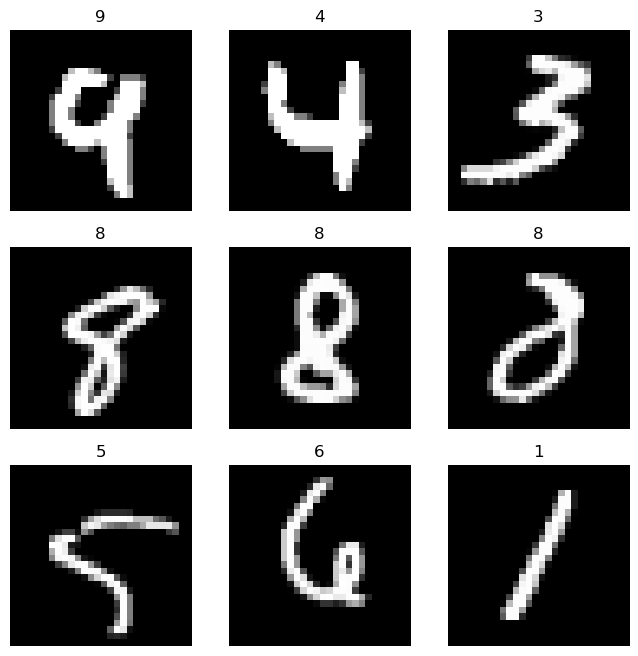

In [21]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size = (1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Создаем DataLoders

In [22]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


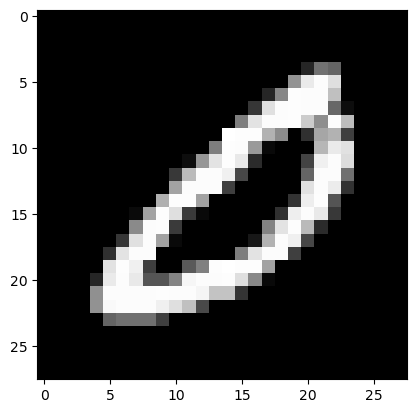

Label: 0


In [23]:
# display image and labels
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Создаем модель

In [24]:
from torch import nn

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [26]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Инициализируем гиперпараметры

In [27]:
learning_rate = 1e-3
batch_size = 64
epochs = 3

## Задаем функию потерь

In [28]:
loss_fn = nn.CrossEntropyLoss()

## Функция оптимизации

In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Циклы обучения и проверки

In [30]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
           loss, current = loss.item(), batch * batch_size + len(X)
           print(f"Loss: {loss:>7f} [{current:>5d}/{size:>5d}]\n")

test_losses = []
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        test_losses.append(test_loss)
    plt.plot(test_losses)
    plt.show()

    print(f"Accurasy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Обучение

Epoch: 1
-------------------------------------
Loss: 2.301431 [   64/60000]

Loss: 2.294386 [ 6464/60000]

Loss: 2.291845 [12864/60000]

Loss: 2.290457 [19264/60000]

Loss: 2.292894 [25664/60000]

Loss: 2.279380 [32064/60000]

Loss: 2.266787 [38464/60000]

Loss: 2.270327 [44864/60000]

Loss: 2.270796 [51264/60000]

Loss: 2.254560 [57664/60000]



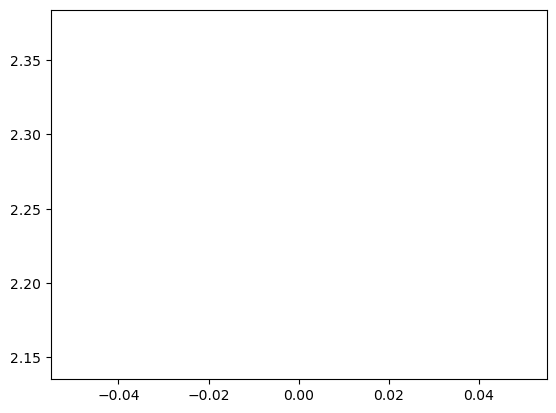

Accurasy: 51.0%, Avg loss: 2.259595 

Epoch: 2
-------------------------------------
Loss: 2.253078 [   64/60000]

Loss: 2.250039 [ 6464/60000]

Loss: 2.255463 [12864/60000]

Loss: 2.241268 [19264/60000]

Loss: 2.248288 [25664/60000]

Loss: 2.221210 [32064/60000]

Loss: 2.231810 [38464/60000]

Loss: 2.215942 [44864/60000]

Loss: 2.191889 [51264/60000]

Loss: 2.198523 [57664/60000]



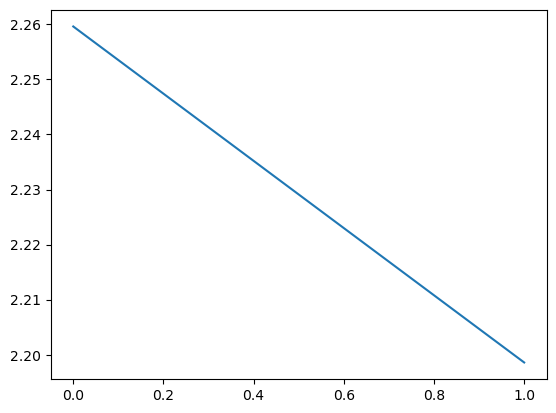

Accurasy: 62.9%, Avg loss: 2.198599 

Epoch: 3
-------------------------------------
Loss: 2.212246 [   64/60000]

Loss: 2.195066 [ 6464/60000]

Loss: 2.194250 [12864/60000]

Loss: 2.165065 [19264/60000]

Loss: 2.178812 [25664/60000]

Loss: 2.148769 [32064/60000]

Loss: 2.146835 [38464/60000]

Loss: 2.128902 [44864/60000]

Loss: 2.115072 [51264/60000]

Loss: 2.104493 [57664/60000]



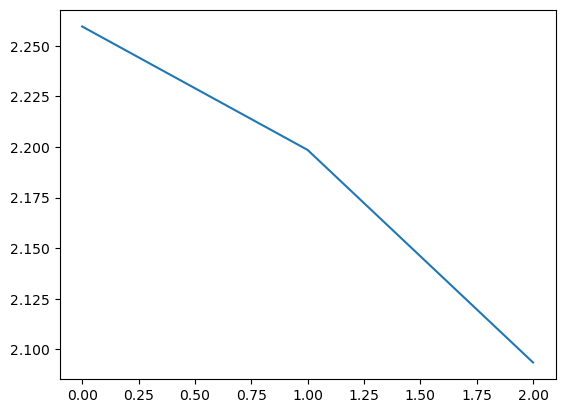

Accurasy: 67.8%, Avg loss: 2.093562 



In [31]:
for t in range(epochs):
    print(f"Epoch: {t+1}\n-------------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)